# Computer Vision Project

#### Approach we will take for the Aerial vs Ground Natural Disaster computer vision project

## Import Packages

In [ ]:
# Get this from GitHub Repository / Random Class Notebooks / etc.

# At minimum, we need PyTorch

# Run this cell only if working in Colab
# Connects to any needed files from GitHub and Google Drive
import os
import getpass

# Remove Colab default sample_data
!rm -r ./sample_data

# # Clone GitHub files to colab workspace
git_user = "sfhorng" # Enter user or organization name
git_email = "sh390@duke.edu" # Enter your email
repo_name = "AIPI-540-CV-Team-2-Project" # Enter repo name
# # Use the below if repo is private, or is public and you want to push to it
# # Otherwise comment next two lines out
git_token = getpass.getpass("enter git token") # Enter your github token 
git_path = f"https://{git_token}@github.com/{git_user}/{repo_name}.git"
!git clone "{git_path}"

# Install dependencies from requirements.txt file
notebook_dir = 'notebooks'
!pip install -r "{os.path.join(repo_name,'requirements.txt')}"

# Change working directory to location of notebook

path_to_data = os.path.join(repo_name,'data/raw')
%cd "{path_to_data}"
%ls

enter git token··········
Cloning into 'AIPI-540-CV-Team-2-Project'...
remote: Enumerating objects: 5363, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 5363 (delta 35), reused 59 (delta 19), pack-reused 5284
Receiving objects: 100% (5363/5363), 1.25 GiB | 40.93 MiB/s, done.
Resolving deltas: 100% (132/132), done.
Checking out files: 100% (5111/5111), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 32.3 MB/s 
/content/AIPI-540-CV-Team-2-Project/data/raw
AIDER_fire/                   flood/                 non_damage.zip.005
AIDER_flood/                  greece_wildfire_2018/  non_damage.zip.006
AIDER_normal.zip.001          kerala_flood_2018/     non_damage.zip.007
AIDER_normal.zip.002          labels/                non_damage.zip.008
california_wildfires.zip.001  main.py                non_damage.zip.009
california

In [ ]:
import os
import urllib.request
import tarfile
import copy
import time
import numpy as np
import pandas as pd
from torchsummary import summary
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pydicom
import cv2
from PIL import Image
import zipfile

import torch
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

torch:  1.11 ; cuda:  cu113


## Load data to our project

In [ ]:
# Reference the following notebooks:
# Image classification (writing neural network from scratch)

from google.colab import drive

drive.mount('/content/drive/')

## AIDER dataset
# Stephanie
path = "/content/drive/My Drive/AIPI-540-Team-2-CV-Project-Datasets/Filtered/AIDER_filtered.zip"
#Amani
#path="/content/drive/My Drive/AIDER_filtered.zip"
zip_ref = zipfile.ZipFile(path, 'r')
zip_ref.extractall(os.getcwd())
zip_ref.close()

## MEDIC dataset
# Stephanie
path = "/content/drive/My Drive/AIPI-540-Team-2-CV-Project-Datasets/data_disaster_types.zip"

zip_ref = zipfile.ZipFile(path, 'r')
zip_ref.extractall(os.getcwd())
zip_ref.close()

Mounted at /content/drive/


## Data Preparation: 
### Set up class to add labels, manipulate the images to size correctly, data augmentation

In [ ]:
# AIDER - use approach based on image classification notebook (writing neural network from scratch)
# MEDIC - need to use DICOM

# labels = Aerial and Ground. Need to standardize "Fire", "Flood", "No Disaster" across both datasets so labels are the same

# Reference code to size images correctly. May not be in correct section, 
# but we might need to compare image sizes across our two data sets and standardize?

# Data augmentation to create new images from AIDER data set to get better class balance between aerial and ground

In [ ]:
# Set up transformations for training and validation (test) data
# For training data we will do randomized cropping to get to 224 * 224, randomized horizontal flipping, and normalization
# For test set we will do only center cropping to get to 224 * 224 and normalization
def get_data_transforms():
    data_transforms = {
      'train': transforms.Compose([
          transforms.RandomResizedCrop(224),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ]),
      'val': transforms.Compose([
          transforms.Resize(256),
          transforms.CenterCrop(224),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ]),
    }
    return data_transforms

In [ ]:
from pandas.core.frame import DataFrame
class CustomDataset(Dataset):
    '''
    Custom PyTorch Dataset for image classification
    Must contain 3 parts: __init__, __len__ and __getitem__
    '''

    def __init__(self, labels_df: DataFrame, data_dir: str, class_mapper: dict, transform=None):
        '''
        Args:
            labels_df (DataFrame): Dataframe containing the image names and corresponding labels
            data_dir (string): Path to directory containing the images
            class_mapper (dict): Dictionary mapping string labels to numeric labels
            transform (callable,optional): Optional transform to be applied to images
        '''
        self.labels_df = labels_df
        self.transform = transform
        self.data_dir = data_dir
        self.classes = self.labels_df['class_label'].unique()
        self.classmapper = class_mapper

    def __len__(self):
        '''Returns the number of images in the Dataset'''
        return len(self.labels_df)

    def __getitem__(self, idx):
        '''
        Returns the image and corresponding label for an input index
        Used by PyTorch to create the iterable DataLoader

        Args:
            idx (integer): index value for which to get image and label
        '''
        # Load the image
        img_path = os.path.join(self.data_dir,
                                self.labels_df.iloc[idx, 0])

        # For a normal image file (jpg,png) use the below
        image = cv2.imread(img_path) # Use this for normal color images
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Use this for color images to rearrange channels BGR -> RGB
        image = Image.fromarray(image) # convert numpy array to PIL image

        # Load the label
        label = self.labels_df.iloc[idx, 1]
        label = self.classmapper[label]

        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [ ]:
def filter_for_existing_paths(df):
    print(f'Number of rows before filtering for existing paths: {len(df)}')
    all_paths = df[['image_path']].values.tolist()
    non_existent_paths = []
    for path in all_paths:
        path = path[0]
        full_path = os.path.join(os.getcwd(), path)
        if not os.path.exists(full_path):
            non_existent_paths.append(path)
    df = df[~df['image_path'].isin(non_existent_paths)]
    print(f'Number of rows after filtering for existing paths: {len(df)}')
    return df

In [ ]:
def generate_medic_filtered_df(type_dataset):
    df = pd.read_csv(os.path.join(os.getcwd(),f'data_disaster_types/consolidated_disaster_types_{type_dataset}_final.tsv'), sep='\t', header=0)
    print(f'Number of rows from original MEDIC {type_dataset} file: {len(df)}')
    condition_1 = df['class_label'] == 'flood'
    condition_2 = df['class_label'] == 'fire'
    condition_3 = df['class_label'] == 'not_disaster'
    filtered_df = df[condition_1 | condition_2 |  condition_3]
    filtered_df = filtered_df[['image_path', 'class_label']]
    filtered_df['image_path'] = 'data_disaster_types/' + df['image_path'].astype(str) # in preparation for combining
    final_df = filter_for_existing_paths(filtered_df)
    return final_df

In [ ]:
AIDER_range = {
    'train': {
        'flood': [101, 526], #0
        'fire': [101,521], #0
        'normal': [1001,4390]
    },
    'val': {
        'flood': [1, 100], #0001 to 0100
        'fire': [1,100], #0001 to 0100
        'normal': [1,1000] # 0001
    }
}

def combine_df(df, type_dataset):
    ranges = AIDER_range[type_dataset]
    all_info = []
    for disaster_type in ranges: # range is flood, fire, normal
        if disaster_type == 'normal':
            normalized_disaster_type = 'not_disaster'
        else:
            normalized_disaster_type = disaster_type
        lower = ranges[disaster_type][0]
        upper = ranges[disaster_type][1]
        for index in range(lower, upper+1): # for each disaster type
            str_index = str(index)
            num_zeros_before = 4 - len(str_index)
            str_num = '0' * num_zeros_before + str(index)
            image_path = f'AIDER_filtered/{type_dataset}/{disaster_type}/{disaster_type}_image{str_num}.jpg'
            all_info.append([image_path, normalized_disaster_type]) 
    new_df = pd.DataFrame(all_info, columns=['image_path', 'class_label'])
    combined_df = pd.concat([df, new_df])
    return combined_df

In [ ]:
def init_custom_dataset(train_df, val_df):
    classes = ['fire','flood', 'not_disaster']
    idx_to_class = {i:j for i,j in enumerate(classes)}
    class_to_idx = {v:k for k,v in idx_to_class.items()}

    data_transforms = get_data_transforms()

    train_dataset = CustomDataset(labels_df=train_df,
                              data_dir=os.getcwd(),
                              class_mapper=class_to_idx,
                              transform = data_transforms['train'])

    val_dataset = CustomDataset(labels_df=val_df,
                              data_dir=os.getcwd(),
                              class_mapper=class_to_idx,
                              transform = data_transforms['val'])
    return train_dataset, val_dataset, idx_to_class

In [ ]:
# Create DataLoaders for training and validation sets
#num_workers:tells dataloader instane how many sub-processes to use for data loading. If zero, GPU has to weight for CPU
#load data.greater num_workers more efficiently the CPU load data and less the GPU has to wait. 
#Google Colab: suggested num_workers=2
def init_dataloaders(train_dataset, val_dataset, batch_size):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                              shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)

    # Set up dict for dataloaders
    dataloaders = {'train':train_loader,'val':val_loader}
    # Store size of training and validation sets
    dataset_sizes = {'train':len(train_dataset),'val':len(val_dataset)}
    return dataloaders, dataset_sizes

Images-AIDER-Train

In [ ]:
def display_images(loader, mapping, batch_size, tensor):
    images, labels = iter(loader).next()
    images = images.numpy()
    fig = plt.figure(figsize=(10, 6))
    for idx in range(batch_size):
        ax = fig.add_subplot(2, batch_size//2, idx+1, xticks=[], yticks=[])
        image = images[idx]
        image = image.transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        ax.imshow(image)
        label = labels[idx]
        if tensor:
            label = label.item()
        ax.set_title("{}".format(mapping[label]))

In [ ]:
def generate_aider_datasets():
    data_transforms = get_data_transforms()
    aider_train_dataset = datasets.ImageFolder(os.path.join(os.getcwd(), 'AIDER_filtered/train'), data_transforms['train'])
    aider_val_dataset= datasets.ImageFolder(os.path.join(os.getcwd(), 'AIDER_filtered/val'), data_transforms['val'])
    class_names = aider_train_dataset.classes
    return aider_train_dataset, aider_val_dataset, class_names

In [ ]:
def generate_medic_datasets():
    medic_train_df = generate_medic_filtered_df('train')
    medic_val_df = generate_medic_filtered_df('test')
    medic_train_dataset, medic_val_dataset, idx_to_class = init_custom_dataset(medic_train_df, medic_val_df)
    return medic_train_dataset, medic_val_dataset, medic_train_df, medic_val_df, idx_to_class

In [ ]:
def generate_combined_datasets(medic_train_df, medic_val_df):
    combined_train_df = combine_df(medic_train_df, 'train')
    combined_val_df = combine_df(medic_val_df, 'val')
    combined_train_dataset, combine_val_dataset, _ = init_custom_dataset(combined_train_df, combined_val_df)
    return combined_train_dataset, combine_val_dataset

# Amani:
## Set up Model Architecture

ResNet50:CNN's have a major disadvantage-'Vanishing Gradient Problem';recall that during backpropagation, the value of gradient decreases significantly, thus hardly any change occurs to the weights.
##ResNet is used to make use of the "Skip Connection"
##Skip connection-adding the orginal input to the output of the convolutional block.

## Train model 

In [ ]:
def train_model(model, criterion, optimizer, dataloaders, scheduler, device, dataset_sizes, num_epochs=25):
    model = model.to(device) # Send model to GPU if available
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Get the input images and labels, and send to GPU if available
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the weight gradients
                optimizer.zero_grad()

                # Forward pass to get outputs and calculate loss
                # Track gradient only for training data
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backpropagation to get the gradients with respect to each weight
                    # Only if in train
                    if phase == 'train':
                        loss.backward()
                        # Update the weights
                        optimizer.step()

                # Convert loss into a scalar and add it to running_loss
                running_loss += loss.item() * inputs.size(0)
                # Track number of correct predictions
                running_corrects += torch.sum(preds == labels.data)

            # Step along learning rate scheduler when in train
            if phase == 'train':
                scheduler.step()

            # Calculate and display average loss and accuracy for the epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # If model performs better on val set, save weights as the best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:3f}'.format(best_acc))

    # Load the weights from best model
    model.load_state_dict(best_model_wts)

    return model

In [ ]:
# Display a batch of predictions
def visualize_results(model,val_loader, device, mapping, tensor):
    model = model.to(device) # Send model to GPU if available
    with torch.no_grad():
        model.eval()
        # Get a batch of validation images
        images, labels = iter(val_loader).next()
        images, labels = images.to(device), labels.to(device)
        # Get predictions
        _,preds = torch.max(model(images), 1)
        preds = np.squeeze(preds.cpu().numpy())
        images = images.cpu().numpy()

    # Plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(15, 10))
    for idx in range(len(preds)):
        ax = fig.add_subplot(2, len(preds)//2, idx+1, xticks=[], yticks=[])
        image = images[idx]
        image = image.transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        ax.imshow(image)
        prediction = preds[idx]
        actual =  labels[idx]
        if tensor:
            prediction = prediction.item()
            actual = actual.item()
        ax.set_title("{} ({})".format(mapping[prediction], mapping[actual]),
                    color=("green" if prediction==actual else "red"))
    return

##Instantiate the model and display(optional)

In [ ]:
def instantiate_train_visualize(net, dataloaders, dataset_sizes, mapping, tensor):
  # Shut off autograd for all layers to freeze model so the layer weights are not trained
  for param in net.parameters():
    param.requires_grad = False

  # Get the number of inputs to final Linear layer
  num_ftrs = net.fc.in_features
  #print(num_ftrs)
  # Replace final Linear layer with a new Linear with the same number of inputs but just 3 outputs,
  # since we have 3 classes - fire, flood and normal or diaster
  net.fc = nn.Linear(num_ftrs, 3)

  # Cross entropy loss combines softmax and nn.NLLLoss() in one single class.
  criterion = nn.CrossEntropyLoss()

  # Define optimizer
  optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

  # Learning rate scheduler - decay LR by a factor of 0.1 every 7 epochs
  lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

  # Set device
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  # Train the model
  net = train_model(net, criterion, optimizer, dataloaders, lr_scheduler, device, dataset_sizes, num_epochs=10)

  # Visualize results 
  visualize_results(net, dataloaders['val'], device, mapping, tensor)

In [ ]:
# Need help putting this into function
# Display a summary of the layers of the model and output shape after each layer
# summary(model,(images.shape[1:]),batch_size=batch_size,device="cpu")

Number of rows from original MEDIC train file: 12846
Number of rows before filtering for existing paths: 7272
Number of rows after filtering for existing paths: 2686
Number of rows from original MEDIC test file: 3195
Number of rows before filtering for existing paths: 1869
Number of rows after filtering for existing paths: 716
MEDIC: {'train': 2686, 'val': 716}
Epoch 0/2
----------
train Loss: 0.4351 Acc: 0.8384
val Loss: 0.1456 Acc: 0.9441

Epoch 1/2
----------
train Loss: 0.3576 Acc: 0.8641
val Loss: 0.1662 Acc: 0.9427

Epoch 2/2
----------
train Loss: 0.3313 Acc: 0.8805
val Loss: 0.1272 Acc: 0.9553

Training complete in 3m 59s
Best val Acc: 0.955307
--------------------


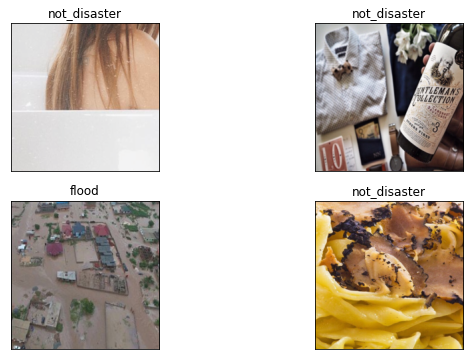

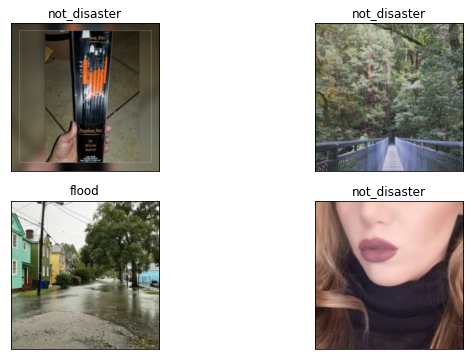

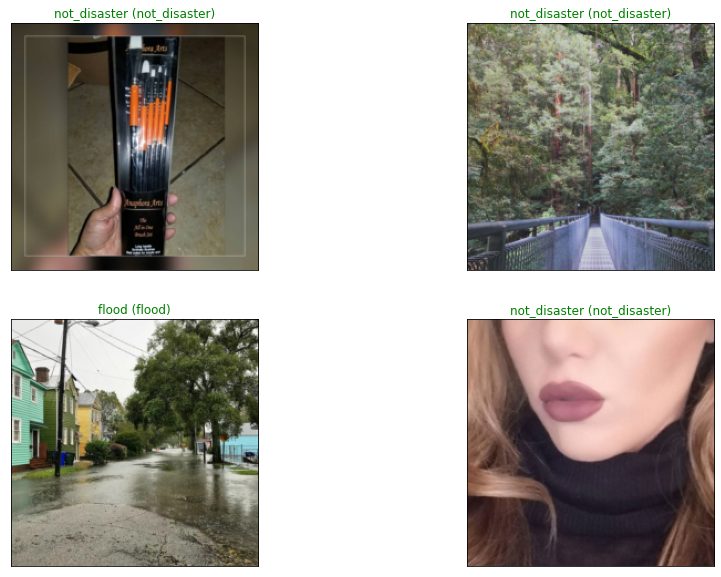

In [ ]:
def main():
    aider_train_dataset, aider_val_dataset, class_names = generate_aider_datasets()
    medic_train_dataset, medic_val_dataset, medic_train_df, medic_val_df, idx_to_class = generate_medic_datasets()
    combined_train_dataset, combined_val_dataset = generate_combined_datasets(medic_train_df, medic_val_df)

    data_sources = {
      'AIDER': {
          'train': aider_train_dataset,
          'val': aider_val_dataset
      },
      'MEDIC': {
          'train': medic_train_dataset,
          'val': medic_val_dataset
      },
      'combined': {
          'train': combined_train_dataset,
          'val': combined_val_dataset
      }
    }

    models = [torchvision.models.resnet50(pretrained=True)]
    batch_size = 4

    for data_source in data_sources:
        train_dataset = data_sources[data_source]['train']
        val_dataset =  data_sources[data_source]['val']
        dataloaders, dataset_sizes = init_dataloaders(train_dataset, val_dataset, batch_size)
        print(f'{data_source}: {dataset_sizes}')
        if data_source == 'AIDER':
            mapping = class_names
            tensor = False
        else:
            mapping = idx_to_class
            tensor = True
        # "Issue" with displaying: Only displays last images, may need to save dl and cn and run in separate cells 
        display_images(dataloaders['train'], mapping, batch_size, tensor)
        display_images(dataloaders['val'], mapping, batch_size, tensor)
        for model in models:
            instantiate_train_visualize(model, dataloaders, dataset_sizes, mapping, tensor)
            print('-' * 20)
main()

### Visualize results

## Data Manipulation

In [ ]:
#MEDIC:
## Choose which pictures to keep from MEDIC (there are a lot more than AIDER)
## Drop pictures we don't want from MEDIC
## Drop Mild Category
## Drop Not Informative label if they exist?
## Only Keep fires, floods, and not disasters

#AIDER:
## Only keep fires, floods and not disasters


## Combine Datasets

In [ ]:
# Merge MEDIC and AIDER

## Train_test_split into our training and test set

In [ ]:
# Set up training, validation, and test sets

# Amani:
## Set up Model Architecture

In [ ]:
# Need to decide on best architecture to use based on our goals. Performance/computational resources tradeoffs

# Are there pre-trained models that are less computationally heavy to start off with? Research this & include in PowerPoint
# Transfer Learning ^

## Train model 

In [ ]:
# Reference existing code to train model

## Evaluate Performance

In [ ]:
# Validation / Test set

## Report on Statistics

In [ ]:
# Performance, recall, F1-score

In [ ]:
# Ground vs Aerial analysis